<a href="https://colab.research.google.com/github/SarahShakhsostad/BankManagementSystem/blob/main/Project_4_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Men-Women detection
###Using Transferlearning+DataAugmentation

In [1]:
import os
import shutil, pathlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

##1- Dataset Preparation

In [2]:
from google.colab import files
_ = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


##1-1-Download Dataset from kaggle

In [4]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 805M/806M [00:23<00:00, 33.3MB/s]
100% 806M/806M [00:23<00:00, 35.6MB/s]


In [5]:
!unzip -qq menwomen-classification.zip

##1-2-Dataset Evaluation

In [6]:
num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))

num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'There are {num_men_train} images of men and {num_women_train} images of women in the training set.')
print(f'There are {num_men_test} images of men and {num_women_test} images of women in the test set.')

There are 1000 images of men and 1912 images of women in the training set.
There are 418 images of men and 915 images of women in the test set.


##1-3-Prepare Data Direction

In [7]:
new_base_dir = pathlib.Path("men_vs_women_small")

def make_subset(base_dir, subset_name, start_index, end_index):
  for category in ("men", "women"):
    dir = new_base_dir / subset_name / category
    if not os.path.exists(dir):
        os.makedirs(dir)
    files = os.listdir(os.path.join (base_dir, category))
    fnames = [files[i] for i in range(start_index, end_index)]
    for fname in fnames:
        shutil.copyfile(src= os.path.join(base_dir, category, fname),
        dst=os.path.join(dir, fname))

In [8]:
make_subset("traindata/traindata", "validation", start_index=0, end_index=200)
make_subset("traindata/traindata", "train", start_index=200, end_index=999)
make_subset("testdata/testdata", "test", start_index=0, end_index=400)

##1-4-Load Dataset

In [9]:
print('Train loader:')
train_dataset = image_dataset_from_directory(
    'men_vs_women_small/train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary')

print('validation loader:')
validation_dataset = image_dataset_from_directory(
    'men_vs_women_small/validation',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary')

print('Test loader:')
test_dataset = image_dataset_from_directory(
    'men_vs_women_small/test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='binary')

Train loader:
Found 1598 files belonging to 2 classes.
validation loader:
Found 400 files belonging to 2 classes.
Test loader:
Found 800 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 1)


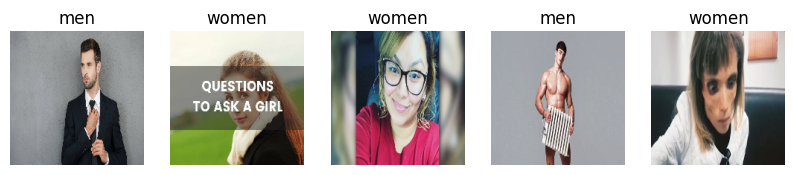

In [10]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)

    fig, axes=plt.subplots(1,5,figsize=(10,3))
    for i,ax in enumerate(axes):
        ax.imshow(data_batch[i].numpy().astype("uint8"))
        ax.set_axis_off()
        ax.set_title("men" if labels_batch[i].numpy()==0 else "women")
    break

##2-Model Design

In [11]:
conv_base = keras.applications.vgg16.VGG16(
     weights='imagenet',
     include_top=False,
     input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
conv_base.trainable = False

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data= validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 312ms/step - accuracy: 0.6465 - loss: 3.8989 - val_accuracy: 0.8400 - val_loss: 1.5194
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 310ms/step - accuracy: 0.7637 - loss: 1.6709 - val_accuracy: 0.8475 - val_loss: 1.5185
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.7714 - loss: 1.6330 - val_accuracy: 0.8650 - val_loss: 1.1804
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.7945 - loss: 1.4911 - val_accuracy: 0.8125 - val_loss: 1.5800
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.7946 - loss: 1.3148 - val_accuracy: 0.8750 - val_loss: 0.9711
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 258ms/step - accuracy: 0.8201 - loss: 0.9922 - val_accuracy: 0.8400 - val_loss: 0.8916
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.8266 - loss: 0.8466 - val_accuracy: 0.8650 - val_loss: 0.9443
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.8467 - loss: 0.6935 - val_accu

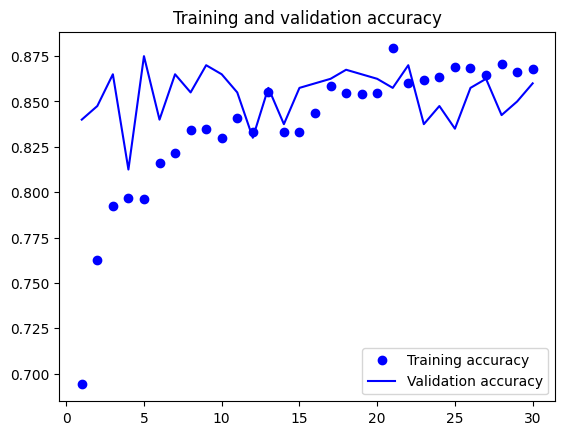

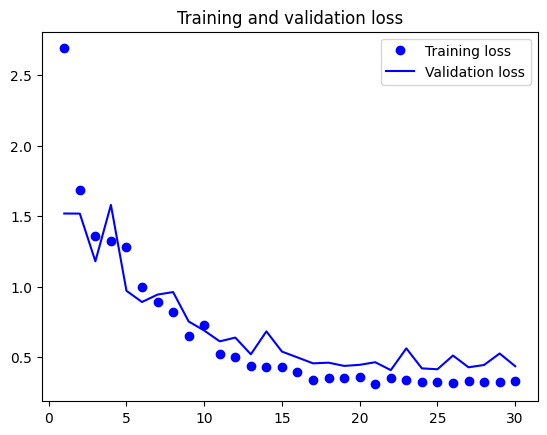

In [17]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.8818 - loss: 0.3387
Test accuracy: 0.875


In [20]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [21]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            257 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,977,860 (57.14 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 131,587 (514.02 KB)

In [22]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 287ms/step - accuracy: 0.8914 - loss: 0.2797 - val_accuracy: 0.8600 - val_loss: 0.4392
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.8972 - loss: 0.2331 - val_accuracy: 0.8675 - val_loss: 0.4269
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - accuracy: 0.9267 - loss: 0.1912 - val_accuracy: 0.8650 - val_loss: 0.4193
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.9340 - loss: 0.1873 - val_accuracy: 0.8825 - val_loss: 0.3907
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.9358 - loss: 0.1350 - val_accuracy: 0.8950 - val_loss: 0.4299
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.9558 - loss: 0.1094 - val_accuracy: 0.8925 - val_loss: 0.4023
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 288ms/step - accuracy: 0.9482 - loss: 0.1172 - val_accuracy: 0.8975 - val_loss: 0.4385
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.9583 - loss: 0.1206 - val_accu

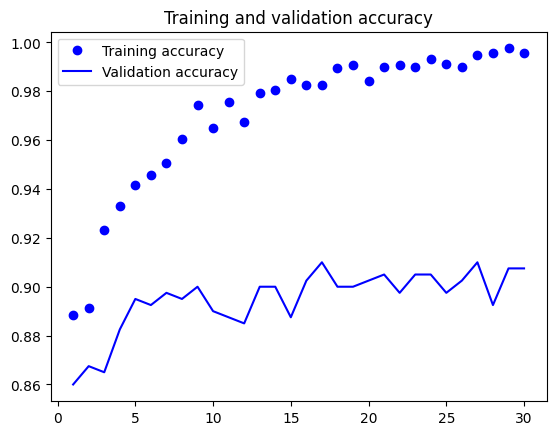

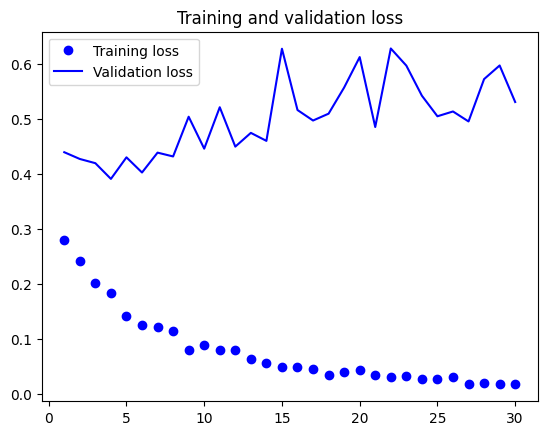

In [24]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [26]:
test_model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9009 - loss: 0.2724
Test accuracy: 0.896


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
!cp 'fine_tuning.keras' '/content/drive/MyDrive/'